In [1]:
#Importing all the necessary header files
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from IPython.display import Image, display
import time
import matplotlib.pyplot as plt

In [2]:
#Reading the content Image and the Style Image
content_image = keras.utils.get_file("DBS_GoldRetriever_1280.jpg","https://cdn.orvis.com/images/DBS_GoldRetriever_1280.jpg")
style_image = keras.utils.get_file("The-Scream.jpg", "https://dam-13749.kxcdn.com/wp-content/uploads/2016/12/The_Scream.jpg")

204800/201816 [==============================] - 0s 0us/step


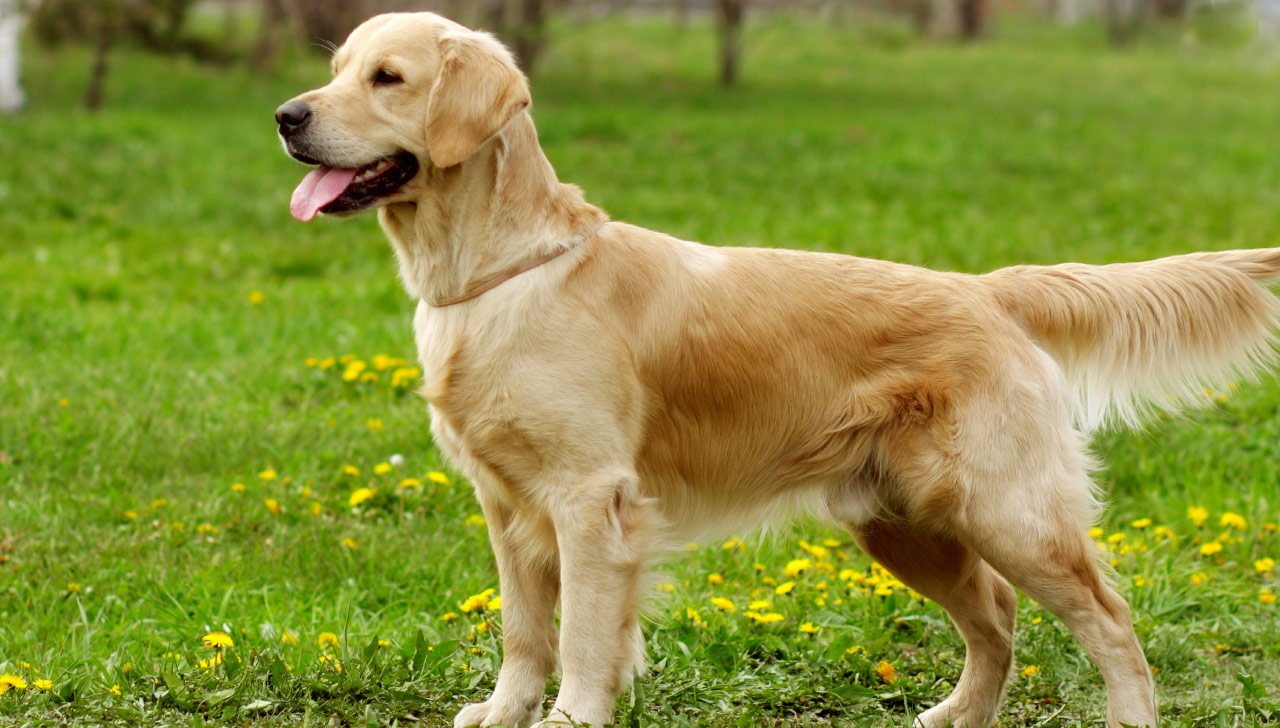

In [3]:
# Displaying the content Image
display(Image(content_image))

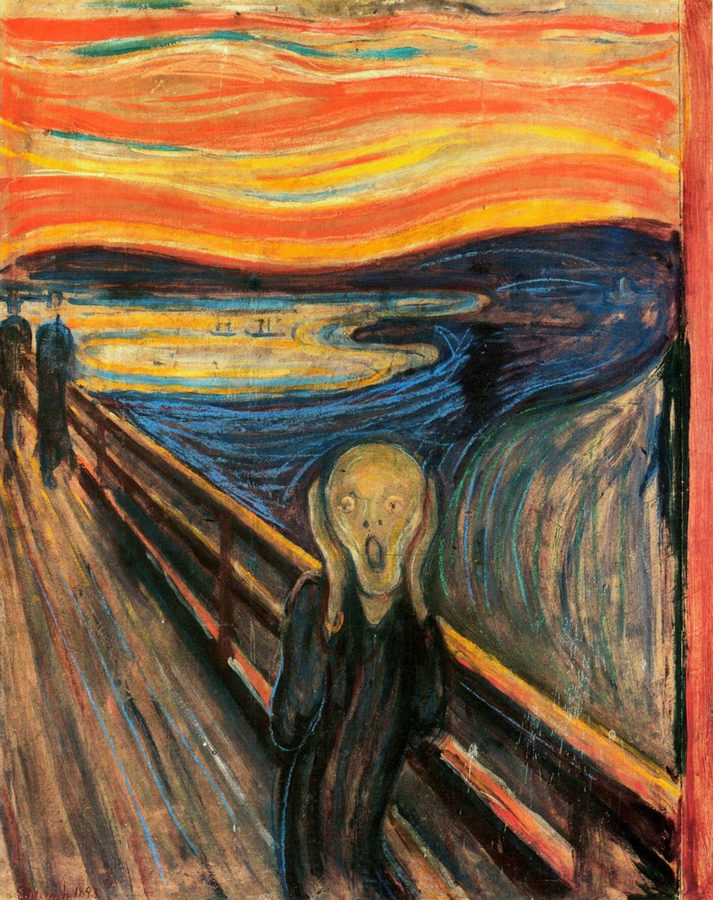

In [4]:
#Displaying the Styled Image
display(Image(style_image))

In [5]:
# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(content_image).size
rows = 400
cols = int(width * rows / height)

In [6]:
# A helper function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(rows, cols))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [7]:
# The below function computes the gram matrix of an image tensor
def gram(z):
    z = tf.transpose(z, (2, 0, 1))
    features = tf.reshape(z, (tf.shape(z)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [8]:
# The style loss functions attempts to maintain the style of the reference image in the generated image. It is based on the gram matrices (which capture style) of feature maps from the style reference image and from the generated image
def style_loss(style, combination):
    S = gram(style)
    C = gram(combination)
    channels = 3
    size = rows * cols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [9]:
# Like the style_loss function above the content_loss function tries to maintain the content of the base image in the generated image
def content_loss(content, combination):
    return tf.reduce_sum(tf.square(combination - content))

In [10]:
# The total variation loss tries to keep the generated image locally coherent

def total_variation_loss(z):
    x = tf.square(
        z[:, : rows - 1, : cols - 1, :] - z[:, 1:, : cols - 1, :]
    )
    y = tf.square(
        z[:, : rows - 1, : cols - 1, :] - z[:, : rows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(x + y, 1.25))

In [11]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

print("The Model Summary for the Pre-Trained VGG-19 Model")
model.summary()

output = dict([(l.name, l.output) for l in model.layers])

# The activation function for every layer in VGG19 (as a dict).
act_feature = keras.Model(inputs=model.inputs, outputs=output)

80142336/80134624 [==============================] - 1s 0us/step
The Model Summary for the Pre-Trained VGG-19 Model
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
___________

In [12]:
# We are cherry picking the layers for the style loss
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# Similarly, we're going to use block5_conv2 for the content loss.
content_layer_name = "block5_conv2"

In [13]:
# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [14]:
# A function to compute all the weighted loss
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = act_feature(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    cl = content_loss(base_image_features, combination_features)
    loss += content_weight * cl

    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    vl = total_variation_loss(combination_image)
    loss += total_variation_weight * vl
    return loss, cl , sl, vl

In [15]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, cl, sl, vl = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads, cl, sl, vl

In [16]:
# Initalizing the optimizer
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

In [17]:
# Pre-processing the input content image, style image and the combiation image

base_image = preprocess_image(content_image)
style_reference_image = preprocess_image(style_image)
combination_image = tf.Variable(preprocess_image(content_image))

In [18]:
# We're going to train the network for 4000 iterations, and paralley store the loss and the image generated
iterations = 4000
loss_store = []
cl_store = []
sl_store = []
vl_store = []
epoch_time_start = int(time.time())
for i in range(0, iterations+1):
    loss, grads, cl,sl,vl = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    loss_store.append(loss)
    cl_store.append(cl)
    sl_store.append(sl)
    vl_store.append(vl)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f " % (i, loss))
        img = combination_image.numpy()
        img = img.reshape((rows, cols, 3))
        img[:, :, 0] += 103.939
        img[:, :, 1] += 116.779
        img[:, :, 2] += 123.68
        img = img[:, :, ::-1]
        img = np.clip(img, 0, 255).astype("uint8")
        fname = "styled_image_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
epoch_time_end = int(time.time())

Iteration 0: loss=43098.00 
Iteration 100: loss=3666.11 
Iteration 200: loss=2759.20 
Iteration 300: loss=2385.60 
Iteration 400: loss=2172.73 
Iteration 500: loss=2031.50 
Iteration 600: loss=1928.89 
Iteration 700: loss=1849.55 
Iteration 800: loss=1786.05 
Iteration 900: loss=1733.96 
Iteration 1000: loss=1690.33 
Iteration 1100: loss=1652.99 
Iteration 1200: loss=1620.67 
Iteration 1300: loss=1592.27 
Iteration 1400: loss=1567.19 
Iteration 1500: loss=1544.95 
Iteration 1600: loss=1525.03 
Iteration 1700: loss=1507.02 
Iteration 1800: loss=1490.67 
Iteration 1900: loss=1475.77 
Iteration 2000: loss=1462.18 
Iteration 2100: loss=1449.73 
Iteration 2200: loss=1438.26 
Iteration 2300: loss=1427.68 
Iteration 2400: loss=1417.92 
Iteration 2500: loss=1408.90 
Iteration 2600: loss=1400.51 
Iteration 2700: loss=1392.67 
Iteration 2800: loss=1385.37 
Iteration 2900: loss=1378.56 
Iteration 3000: loss=1372.19 
Iteration 3100: loss=1366.19 
Iteration 3200: loss=1360.56 
Iteration 3300: loss=

In [19]:
print("Time Taken for all the epocs (in seconds): ",epoch_time_end-epoch_time_start)

Time Taken for all the epocs (in seconds):  1235


In [20]:
# Plot Curves
def plot_graph(epocs,attribute_a,attribute_b,attribute_c,attribute_d):
  fig, ax = plt.subplots(2, 2,figsize=(10,10))

  ax[0,0].plot(range(epocs),attribute_a[:epocs],'-',color='green',linewidth=3,label='Content Loss')
  #ax[0,0].xlabel('epoch')
  #ax[0,0].ylabel(loss_name)
  ax[0,0].grid(True)
  ax[0,0].legend()

  ax[1,0].plot(range(epocs),attribute_b[:epocs],'-',color='orange',linewidth=3,label='Style Loss')
  #ax[1,0].xlabel('epoch')
  #ax[1,0].ylabel(loss_name)
  ax[1,0].grid(True)
  ax[1,0].legend()

  ax[0,1].plot(range(epocs),attribute_c[:epocs],'-',color='red',linewidth=3,label='Variation Loss')
  #ax[0,1].xlabel('epoch')
  #ax[0,1].ylabel(loss_name)
  ax[0,1].grid(True)
  ax[0,1].legend()

  ax[1,1].plot(range(epocs),attribute_d[:epocs],'-',color='blue',linewidth=3,label='Overall Loss')
  #ax[1,1].xlabel('epoch')
  #ax[1,1].ylabel(loss_name)
  ax[1,1].grid(True)
  ax[1,1].legend()

  plt.setp(ax[0, 0], xlabel='Iteration', ylabel='Loss')
  plt.setp(ax[0, 1], xlabel='Iteration', ylabel='Loss')
  plt.setp(ax[1, 0], xlabel='Iteration', ylabel='Loss')
  plt.setp(ax[1, 1], xlabel='Iteration', ylabel='Loss')

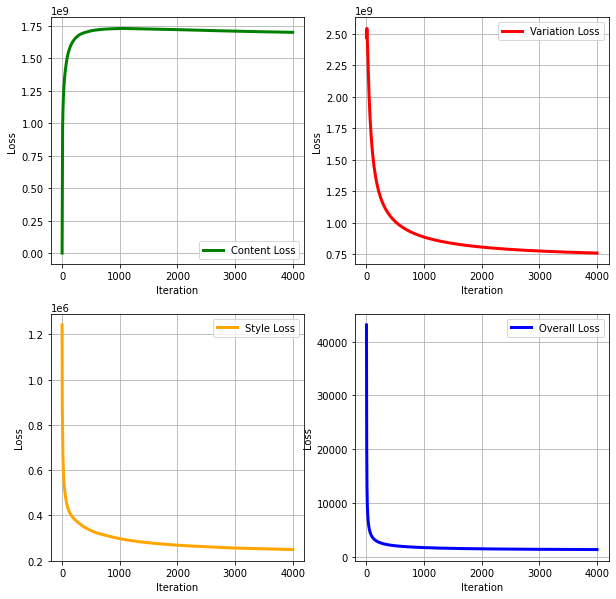

In [21]:
plot_graph(4000,cl_store,sl_store,vl_store,loss_store)





*   Display Image at 25, 75, 200
*   Time taken to train for 1000 epochs







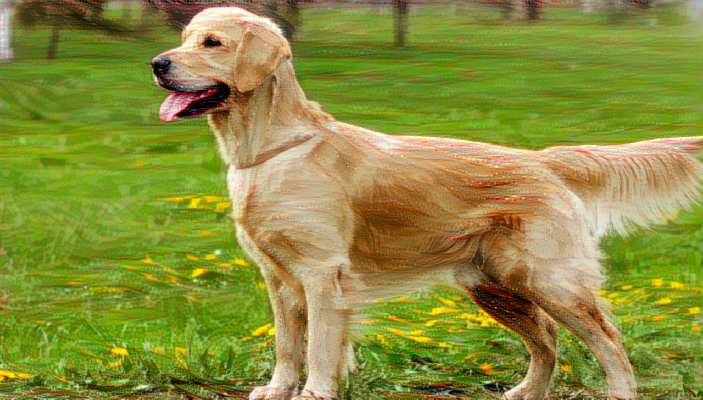

In [27]:
display(Image("styled_image_at_iteration_100.png"))

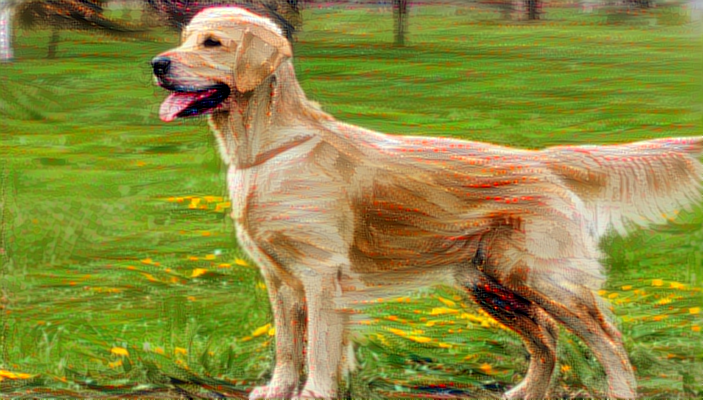

In [28]:
display(Image("styled_image_at_iteration_500.png"))

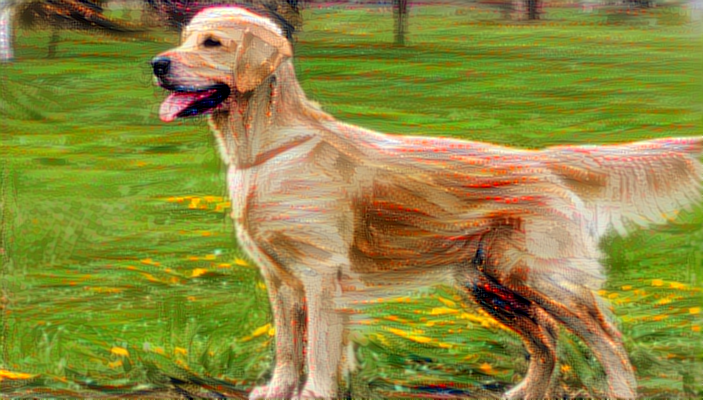

In [29]:
display(Image("styled_image_at_iteration_1000.png"))

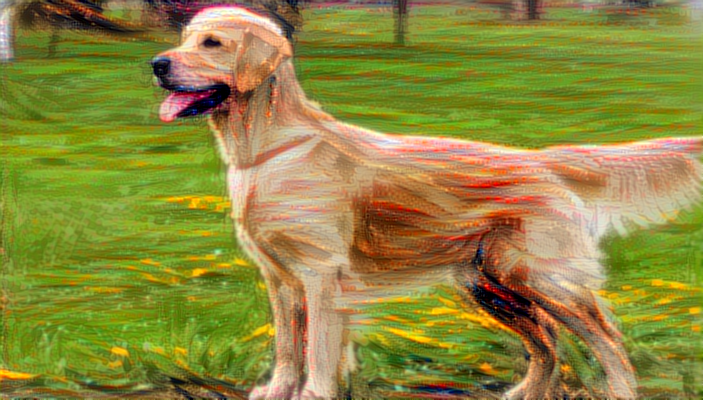

In [30]:
display(Image("styled_image_at_iteration_2000.png"))

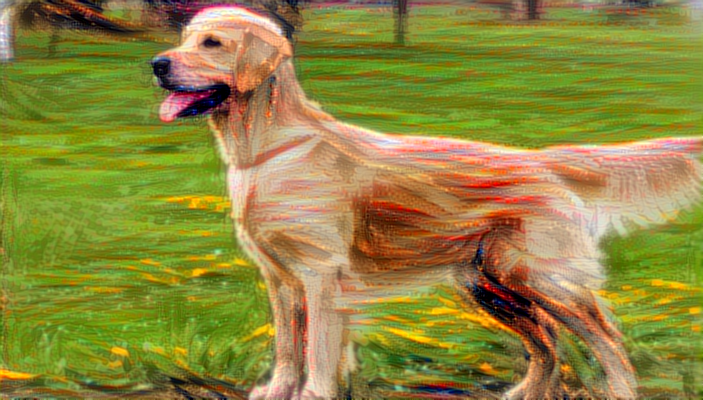

In [31]:
display(Image("styled_image_at_iteration_3000.png"))

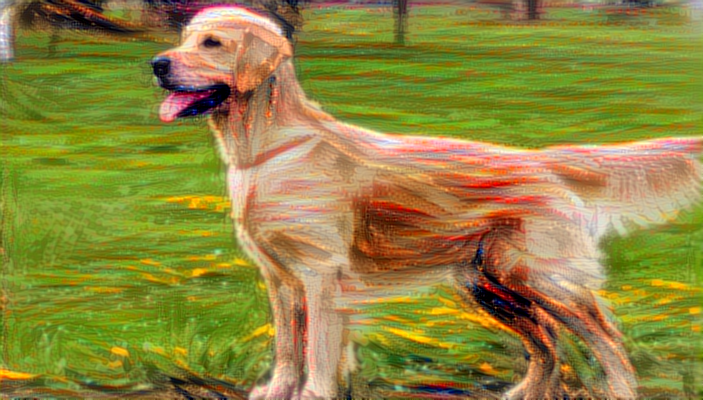

In [32]:
display(Image("styled_image_at_iteration_4000.png"))